<a href="https://colab.research.google.com/github/laurilaatu/malis/blob/master/MALIS_Project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MALIS 2019 EURECOM
## Course Project

This is version zero of our semester project. We will load and prepare the data. Train a CNN to to extract features and use an ANN or SVM to classify the images.

### Description

**Task 1**: **bold text** Project definition for Group 34
	By:
Lauri Laatu
Marvin Mouroum


**•Context & problem definition**

Classifying images is a huge topic in machine learning. The goal for our project is to be able to classify images to multiple classes. More specifically we want to investigate if a simple convolutional neural network is able to classify internet memes correctly. As such our it is a supervised learning problem.


**•Methodology**

Convolution for feature extraction
RGB images will be fetched from a database
preprocessing to optimize image dimensions
convolution over three color channels of the images
exporting a feature vector containing compressed information about the image
ANN or SVM for classification based on extracted features
feature vectors as labeled input
supervised multiclass classification problem
dataset usage: initially we plan to start with n-fold cross validation and 10% testing
classification in predefined meme categories


**•Data**

The data will be acquired from the internet and labeled by hand if the data is unlabelled. Goal is to find around a thousand images per class.


# Dataset
Loading data from the dataset

In [0]:
import os.path
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
from googleapiclient.http import MediaIoBaseDownload
from google.colab import drive as gdrive
from pydrive.auth import GoogleAuth

from IPython.display import Image

In [0]:
auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
gdrive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Copy raw pepe images to local directory

In [0]:
!mkdir  dataset

file_list = drive.ListFile({'q': "'10DpgRQAxqIU0TLYCruSGPaj3DfRzh6TE' in parents and trashed=false"}).GetList()

root = "/content/drive/My Drive/MALIS_Project/DataSet/rare-pepes/"
i = 0

#!cp "/content/drive/My Drive/MALIS_Project/DataSet/rare-pepes/001 - OdrldTF.png" "dataset/pepe_00.png"

for file in file_list:
  target = "'dataset/pepe_"+str(i)+".png'"
  src    = "'"+root+file['title']+"'"
  #print(src)
  #print(target)
  !cp $src $target
  i+=1

!ls -1 dataset



### Resizing Image so it can be used by the CNN

In [0]:
def resize_img(img,destination):
  # Create square images from pepes by adding black margins preserving original aspect ratio
  #Importing modules opencv + numpy
  import cv2
  import numpy as np

  #Reading an image (you can use PNG or JPG)
  img = cv2.imread(img)

  if img is None:
    return False

  #Getting the bigger side of the image
  s = max(img.shape[0:2])

  #Creating a dark square with NUMPY  
  f = np.zeros((s,s,3),np.uint8)

  #Getting the centering position
  ax,ay = (s - img.shape[1])//2,(s - img.shape[0])//2

  #Pasting the 'image' in a centering position
  f[ay:img.shape[0]+ay,ax:ax+img.shape[1]] = img

  #Showing results (just in case) 
  #cv2.imshow("IMG",f)
  #A pause, waiting for any press in keyboard
  #cv2.waitKey(0)

  #Saving the image
  f = cv2.resize(f,(227,227),interpolation=cv2.INTER_AREA)
  cv2.imwrite(destination,f)
  cv2.destroyAllWindows() 
  return True

In [0]:
!mkdir resized
for i in range(0,1273):
  path =   "dataset/pepe_" + str(i) + ".png"
  _path = "'resized/pepe_" + str(i) + ".png'"
  prev_dest = "resized/pepe_" + str(i) + ".png"
  destination = "'/content/drive/My Drive/MALIS_Project/DataSet/resized_pepe/pepe_" + str(i) + ".png'"
  if not resize_img(path,prev_dest):
    print("error with", i)
  !cp $_path $destination 
  if(i%50 == 0):
    print(i)

### Prepare the Not Pepe Images

In [0]:
file_list = drive.ListFile({'q': "'1UBhhkryHE302KDQ8ufDvkfv7vozMZfli' in parents and trashed=false"}).GetList()

!mkdir dataset

root = "/content/drive/My Drive/MALIS_Project/DataSet/not-pepes/"
i = 0
rootfolder = "'"+root+"'"

#!cp "/content/drive/My Drive/MALIS_Project/DataSet/rare-pepes/001 - OdrldTF.png" "dataset/pepe_00.png"

for file in file_list:
  target = "dataset/not_pepe_"+str(i)+"."+file['title'].split('.')[-1]
  src    =  root+file['title']
  _src   = "'"+target+"'"  
  _target = "'/content/drive/My Drive/MALIS_Project/DataSet/resized_not_pepe/not_pepe_"+str(i)+"."+file['title'].split('.')[-1]+"'"
  
  if not resize_img(src,target):
    print("error with", i)
    continue
  !cp $_src $_target
  i+=1

In [0]:
!ls '/content/drive/My Drive/MALIS_Project/DataSet/not-pepes/'

# Network

In [0]:
## PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import Tensor
import torch.optim as optim
import torchvision

import math #for calculus
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

from sklearn import svm

Defining the Network class

In [0]:
class PepeNN(nn.Module):   
    
    def __init__(self,name='PepeNN'):
        super(PepeNN, self).__init__()
        self.T = 120
        
        self.name = name
        
        self.training_epochs = 0
        
        self.lr_history       = []
        self.accuracy_history = []
        self.loss_history     = []
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        #torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

        self.conv1 = nn.Conv2d(3,20,  kernel_size=(11,11),stride=(4,4),padding=(1,1),dilation=(1,1))
        self.batchnorm1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20,40,kernel_size=(5,5),stride=(2,2),padding=(1,1),dilation=(1,1))
        self.batchnorm2 = nn.BatchNorm2d(40)

        self.pooling1 = nn.MaxPool2d( kernel_size=(5,5), stride=(2,2), padding=(1,1), dilation=(1,1))

        self.conv3 = nn.Conv2d(40,20,kernel_size=(3,3),stride=(2,2),padding=(1,1),dilation=(1,1))
        self.batchnorm3 = nn.BatchNorm2d(20)
        self.conv4 = nn.Conv2d(20,10,kernel_size=(2,2),stride=(1,1),padding=(0,0),dilation=(1,1))
        self.batchnorm4 = nn.BatchNorm2d(10)

        self.pooling2 = nn.MaxPool2d(kernel_size=(2,2), stride=(1,1), padding=(0,0), dilation=(1,1))
        
        #fully connected at the end

        self.fc1 = torch.nn.Linear(in_features=250, out_features=2)
        #self.fc1 = torch.nn.Linear(in_features=250, out_features=125)
        #self.fc2 = torch.nn.Linear(in_features=125, out_features=2)
    
        
        # robust weight initialization
        torch.nn.init.xavier_normal_(self.conv1.weight)
        torch.nn.init.xavier_normal_(self.conv2.weight)
        torch.nn.init.xavier_normal_(self.conv3.weight)
        torch.nn.init.xavier_normal_(self.conv4.weight)

        torch.nn.init.xavier_normal_(self.fc1.weight)
        #torch.nn.init.xavier_normal_(self.fc2.weight)

        self.SVM = svm.LinearSVC()
        self.svm_train_input = []
        self.svm_label_input = []
        self.svm_active = False
        self.SVM.max_iter = 10000
        self.SVM.C = 0.01
      

        
    def forward(self, x):

        batchSize = x.shape[0]

        # first set of CNNs and then a max pool
        #print("starting with " + str(x.shape))
        x = self.conv1(x)
       # print("after 1 " + str(x.shape))
        x = self.batchnorm1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        #print("after 2 " + str(x.shape))
        x = self.batchnorm2(x)
        x = F.relu(x)
        
        x = self.pooling1(x)
        #print("after 3 " + str(x.shape))
        
        # second set
        
        x = self.conv3(x)
        #print("after 4 " + str(x.shape))
        x = self.batchnorm3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        #print("after 5 " + str(x.shape))
        x = self.batchnorm4(x)
        x = F.relu(x)
        
        x = self.pooling2(x)
        #print("after 6 " + str(x.shape))
        mean = x.mean()
        std = x.std()
        svm_input = (x - mean)/std
        res = []

        if self.svm_active:
          if len(self.svm_train_input) == 0:
            self.svm_train_input.append(svm_input)
          else:

            if self.svm_train_input[0].ndim == 5:
              n = self.svm_train_input[0].shape[0]
              b = self.svm_train_input[0].shape[1]
              h = self.svm_train_input[0].shape[2]
              w = self.svm_train_input[0].shape[3]
              d = self.svm_train_input[0].shape[4]

              self.svm_train_input[0] = torch.cat([self.svm_train_input[0], svm_input.reshape([1,b,h,w,d])], dim=0)
            else:
              self.svm_train_input[0] = torch.stack([self.svm_train_input[0], svm_input], dim=0)

        else:
          b,h,w,d = svm_input.shape
          predict_input = svm_input.clone().detach().cpu().reshape(b,h*w*d).tolist()
          res = self.SVM.predict(predict_input)

        x= self.fc1(x.reshape((batchSize,250)))
        #x= self.fc2(x)

        x= F.softmax(x,dim=1)
        
        return x, res
      
    def save(self,root='gdrive/My\ Drive/MALIS_Project'):
      !mkdir $root
  
      path = root.replace('\\','') + '/' + self.name + '.pickle'
    
      print("\nsaving network under:\n",path)
      
      with open(path, 'wb') as f:
        pickle.dump(self, f)
        
    def next_epoch(self,lr,acc_hist,loss_hist):
      self.training_epochs += 1
      self.lr_history.append(lr)
      self.accuracy_history.append(acc_hist)
      self.loss_history.append(loss_hist)
    
    def reset(self):
      self.training_epochs = 0
      self.lr_history = []
      self.accuracy_history = []
      self.loss_history = []

    def train_svm(self):
      #print(len(self.svm_train_input))
      #print(len(self.svm_label_input))
      #print(self.svm_train_input[0].shape)
      #print(self.svm_label_input[0].shape)

      inputs = []
      labels = []

      i_clone = self.svm_train_input[0].clone().detach().cpu().numpy()
      i_clone = i_clone.reshape(i_clone.shape[0]*i_clone.shape[1],i_clone.shape[2]*i_clone.shape[3]*i_clone.shape[4])
      inputs = i_clone.tolist()

      l_clone = self.svm_label_input[0].clone().detach().cpu().numpy() 
      l_clone = l_clone.reshape(l_clone.shape[0]*l_clone.shape[1])
      labels = l_clone.tolist()


      #print(len(inputs))
      #print(len(labels))

      #print(inputs[0])
      #print(labels[0])

      self.SVM.fit(inputs, labels)

    def add_svm_labels(self,labels):
      if len(self.svm_label_input) == 0:
        #print("first append svm training label")
        self.svm_label_input.append(labels)
      else:

        if self.svm_label_input[0].ndim == 2:
          n = self.svm_label_input[0].shape[0]
          b = self.svm_label_input[0].shape[1]

          #print(self.svm_label_input[0].shape)
          #print(labels.reshape([1,b]).shape)

          self.svm_label_input[0] = torch.cat([self.svm_label_input[0], labels.reshape([1,b])], dim=0)
        else:
          #print(self.svm_label_input[0].shape)
          #print(labels.shape)
          self.svm_label_input[0] = torch.stack([self.svm_label_input[0], labels], dim=0)

        
      #self.svm_label_input.append(labels)
    
    def newEpoch(self):
      self.svm_train_input.clear()
      self.svm_label_input.clear()


Creating n folds

In [6]:
#!ls "/content/drive/My Drive/MALIS_Project/DataSet/"


# id for Dataset folder 1ugHotUpAsw1o-V8JvN7JwEXWNv-tTp-i

file_list = drive.ListFile(
    {'q': "'1ugHotUpAsw1o-V8JvN7JwEXWNv-tTp-i' in parents"}).GetList()

# create an array of tuples with (id, label, fold,file)

dataset = []
npepes = []

pepes = []

for i in file_list:
  if "resized" in i['title']:
    if "not" in i['title']:
      print(i)
      for notpepe in drive.ListFile({'q': "'%s' in parents"%(i['id']) }).GetList():
        # 
        npepes.append((len(dataset), 0, None, notpepe))
      #print(i)
    else:
      for pepe in drive.ListFile({'q': "'%s' in parents"%(i['id']) }).GetList():
        # 
        pepes.append((len(dataset), 1, None, pepe))      
      #print(i)
  

print(len(npepes),len(pepes))

folds = 10
for fold in range(folds):
  foldsize = int(len(npepes)/folds)
  for i in range(fold*foldsize, (fold+1)*foldsize):
    npepes[i] = (npepes[i][0], npepes[i][1], fold, npepes[i][3])

for i in range(len(npepes)-1,1, -1):
  if npepes[i][2] is None:
    npepes[i] = (npepes[i][0], npepes[i][1], folds-1, npepes[i][3])
  else:
    break

for fold in range(folds):
  foldsize = int(len(pepes)/folds)
  for i in range(fold*foldsize, (fold+1)*foldsize):
    pepes[i] = (pepes[i][0], pepes[i][1], fold, pepes[i][3])

for i in range(len(pepes)-1,1, -1):
  if pepes[i][2] is None:
    pepes[i] = (pepes[i][0], pepes[i][1], folds-1, pepes[i][3])
  else:
    break

for x in npepes[-5:]:
  print(x)

for x in pepes[-5:]:
  print(x)

# now we have labeled dataset partitioned into n number of folds  
dataset = npepes+pepes
print(len(dataset))


    

#print(file_list)

GoogleDriveFile({'kind': 'drive#file', 'id': '10R3BKAh8LzgqP1bYFYZGlEVL-9C1KNo3', 'etag': '"30jMLj3-m0JdGNLPUS2QqbEXiN0/MTU3NjUzNjg5OTE0Ng"', 'selfLink': 'https://www.googleapis.com/drive/v2/files/10R3BKAh8LzgqP1bYFYZGlEVL-9C1KNo3', 'alternateLink': 'https://drive.google.com/drive/folders/10R3BKAh8LzgqP1bYFYZGlEVL-9C1KNo3', 'embedLink': 'https://drive.google.com/embeddedfolderview?id=10R3BKAh8LzgqP1bYFYZGlEVL-9C1KNo3', 'iconLink': 'https://drive-thirdparty.googleusercontent.com/16/type/application/vnd.google-apps.folder+shared', 'title': 'resized_not_pepe', 'mimeType': 'application/vnd.google-apps.folder', 'labels': {'starred': False, 'hidden': False, 'trashed': False, 'restricted': False, 'viewed': True}, 'copyRequiresWriterPermission': False, 'createdDate': '2019-12-16T22:54:59.146Z', 'modifiedDate': '2019-12-16T22:54:59.146Z', 'modifiedByMeDate': '2019-12-16T22:54:59.146Z', 'lastViewedByMeDate': '2020-01-08T17:17:02.646Z', 'markedViewedByMeDate': '1970-01-01T00:00:00.000Z', 'version

In [0]:
dataset[3000]

### Methods for training the network

Some methods...

In [0]:
def get_cost_function():
    
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function
    
def get_optimizer(net, lr, wd, momentum):
  #optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=wd, amsgrad=False)
  return optimizer

In [0]:
def test(net,t_data,t_labels, cost_function, device='cuda:0'):
  
  net.eval()
  net.svm_active = False

  cumulative_loss = 0
  accuracy = 0
  svm_accuracy = 0

  samples = t_data.shape[0]

  misclassified_imgs = []
  svm_misclassified_imgs = []
  
  with torch.no_grad():

    mean = t_data.mean()
    std  = t_data.std()
      
    t_data = (t_data - mean)/std
      
    # Load data into GPU
    inputs = torch.LongTensor(t_data).float().to(device)
    targets = torch.LongTensor(t_labels).to(device)
        
    # Forward pass
    outputs, svm_outputs = net(inputs)
      
    # Apply the loss
    loss = cost_function(outputs, targets)

    #print("loss " +str(loss))
    cumulative_loss += loss.item()
    #print("cim loss " +str(cumulative_loss))
    _, predicted = outputs.max(1)
    svm_predicted = torch.LongTensor(svm_outputs)
    #print("ourputs -> " , outputs)
    #print("predicted -> " , predicted)
    #print("targets   -> " , targets)

    misclassified = (predicted.eq(targets) == 0).nonzero()
    for i in misclassified:
        misclassified_imgs.append((i, predicted[i]))

    svm_misclassified = (svm_predicted.eq(targets.clone().cpu().detach()) == 0).nonzero()
    for i in svm_misclassified:
        svm_misclassified_imgs.append((i, svm_predicted[i]))

    accuracy += predicted.eq(targets).sum().item()/samples
    svm_accuracy += svm_predicted.eq(targets.clone().cpu().detach()).sum().item()/samples
    #print("accuracy " + str(accuracy))

  return cumulative_loss, accuracy, svm_accuracy, misclassified_imgs, svm_misclassified_imgs

In [0]:
def train(net,t_data,t_labels,optimizer,cost_function, device='cuda:0'):
  net.train()
  net.svm_active = True

  cumulative_loss = 0
  accuracy = 0

  samples = t_data.shape[0]

  mean = t_data.mean()
  std  = t_data.std()
      
  t_data = (t_data - mean)/std
      
  # Load data into GPU
  inputs = torch.LongTensor(t_data).float().to(device)
  targets = torch.LongTensor(t_labels).to(device)
        
  # Forward pass
  outputs, svm_inputs = net(inputs)
  net.add_svm_labels(targets)
      
  # Apply the loss
  loss = cost_function(outputs, targets)

  # Backward pass
  loss.backward()
    
  # Update parameters
  optimizer.step()
    
  # Reset the optimizer
  optimizer.zero_grad()

  #print("loss " +str(loss))
  cumulative_loss += loss.item()
  #print("cim loss " +str(cumulative_loss))
  _, predicted = outputs.max(1)
  #print("ourputs -> " , outputs)
  #print("predicted -> " , predicted)
  #print("targets   -> " , targets)
  accuracy += predicted.eq(targets).sum().item()/samples
  #print("accuracy " + str(accuracy))

  return cumulative_loss, accuracy

In [0]:
from random import shuffle

#dataset[3000][1] -> label
#dataset[3000][2] -> n fold


#first_fold = list(filter(lambda x: x[2] == 0, dataset))
#second_fold = list(filter(lambda x: x[2] == 1, dataset))
#third_fold = list(filter(lambda x: x[2] == 2, dataset))
#fourth_fold = list(filter(lambda x: x[2] == 3, dataset))
#fifth_fold = list(filter(lambda x: x[2] == 4, dataset))
#sixth_fold = list(filter(lambda x: x[2] == 5, dataset))
#print(len(first_fold))

#trainingData = [first_fold,second_fold,third_fold,fourth_fold,fifth_fold,sixth_fold]
shuffle(dataset)
trainingData = [ list(filter(lambda x: x[2] == i, dataset)) for i in range(folds-1) ]
test_data = list(filter(lambda x: x[2] == folds-1, dataset))

def getTrainingData(n_fold):

  shuffle(n_fold)

  images  = list(map(lambda x: x[3], n_fold))
  classes  = list(map(lambda x: x[2], n_fold))
  labels = list(map(lambda x: x[1], n_fold))

  imageArray = np.zeros((len(images),227,227,3))

  for i in range(0,len(images)):
    standard = 'drive/My Drive/'
    root = standard + 'MALIS_Project/DataSet/'

    if (labels[i] == 0):
      root = root + 'resized_not_pepe/'

    else:
      root = root + 'resized_pepe/'

    filepath = root + images[i]['title']
    image = cv2.imread(filepath) #numpy array
    if image.size == 0:
      print("empty image")
    imageArray[i] = image

  return imageArray, labels




In [0]:
#net = PepeNN()

In [25]:

device='cuda:0'

testLoss = 0
trainLoss = 0
total_acc = 0
counter = 0

max_epochs = 12
lr = 0.001

nets = []

for _n_ in range(0,folds-1):

  print("CROSS VALIDATION\nTesting will be on fold ", _n_)

  nets.append(PepeNN())
  nets[-1].to(device)

  for e in range(0,max_epochs):

    if counter > 0 and total_acc/counter > 0.99:
      print("accuracy high enough aborting")
      break

    print("On epoch " , e+1)
    nets[-1].newEpoch()

    for _n in range(0,folds-1):

      if _n == _n_:
        continue
      
      print("Training on fold ", _n)

      imageArray, labels = getTrainingData(trainingData[_n])
      a=0
      n=20
      N= imageArray.shape[0]

      intervall = n-a

      for i in range(0,N,intervall):
    
        a = i
        n = i + intervall

        if n >= N:
          continue

        t_data   = np.transpose(imageArray[a:n].reshape((n-a,227,227,3)), (0,3, 1, 2))
        t_labels = np.array([labels[a:n]]).reshape((n-a,))

        if t_data.size == 0:
          print("skip")
          continue

        optimizer = get_optimizer(nets[-1], lr=lr, wd=1e-6, momentum=0.9)

        Loss, accuracy = train(nets[-1],t_data,t_labels,optimizer,get_cost_function(),device)
        trainLoss += Loss
        #print("accumulated loss = " +str(trainLoss))
        #print("accuracy -> " + str(accuracy))
        total_acc += accuracy
        counter += 1

    print("accuracy ",total_acc/counter)
    print("-----------------------------\n")
    
    total_acc = 0
    counter = 0
    
  nets[-1].train_svm()

  #test the network
  t_acc,s_acc,net_list,svm_list = test_n_fold(_n_,data=trainingData,show=False)

  print("\nSummary: " , _n_)
  print("net accuracy: ", t_acc)
  print("svm accuracy: ", s_acc)
  print("\n---------------------")



CROSS VALIDATION
Testing will be on fold  0
On epoch  1
Training on fold  1
Training on fold  2
Training on fold  3
Training on fold  4
Training on fold  5
Training on fold  6
Training on fold  7
Training on fold  8
accuracy  0.8105468749999998
-----------------------------

On epoch  2
Training on fold  1
Training on fold  2
Training on fold  3
Training on fold  4
Training on fold  5
Training on fold  6
Training on fold  7
Training on fold  8
accuracy  0.8863281250000006
-----------------------------

On epoch  3
Training on fold  1
Training on fold  2
Training on fold  3
Training on fold  4
Training on fold  5
Training on fold  6
Training on fold  7
Training on fold  8
accuracy  0.8976562500000005
-----------------------------

On epoch  4
Training on fold  1
Training on fold  2
Training on fold  3
Training on fold  4
Training on fold  5
Training on fold  6
Training on fold  7
Training on fold  8
accuracy  0.9152343750000009
-----------------------------

On epoch  5
Training on fold

In [0]:
net.SVM.C = 0.01
net.train_svm()

In [0]:
from google.colab.patches import cv2_imshow

def test_n_fold(n_fold,data=trainingData,net=nets[-1], show=True):
  font                   = cv2.FONT_HERSHEY_SIMPLEX
  fontScale              = .5
  fontColor              = (220,220,220)
  lineType               = 2

  print("\n TESTING on fold ", n_fold)

  imageArray, labels = getTrainingData(data[n_fold])
  N= imageArray.shape[0]

  tot_acc = 0
  tot_svm_acc = 0
  samples = 0

  svm_wrong_list = []
  net_wrong_list = []

  for i in range(0,N,20):
    a = i
    n = i + 20
    if n > N:
      break

    t_data   = np.transpose(imageArray[a:n].reshape((n-a,227,227,3)), (0,3, 1, 2))
    t_labels = np.array([labels[a:n]]).reshape((n-a,))
    tLoss, taccuracy, svm_acc, missclassified, svm_missclassified  = test(nets[-1],t_data,t_labels,get_cost_function(),device)
    tot_acc += taccuracy
    tot_svm_acc += svm_acc
    samples += 1

    for i in missclassified:
      #print("net classified as:", str(i[1]), i)
      img = imageArray[a:n][i[0]]
      cv2.putText(img,
            'Not PEPE' if i[1] == 0 else "PEPE", 
            (15,15), 
            font, 
            fontScale,
            fontColor,
            lineType)
      if show:
        cv2_imshow(img)
      net_wrong_list.append(img)

    for i in svm_missclassified:
      #print("svm classified as:", str(i[1]), i)
      img = imageArray[a:n][i[0]]
      cv2.putText(img,
            'Not PEPE' if i[1] == 0 else "PEPE", 
            (15,15), 
            font, 
            fontScale,
            fontColor,
            lineType)
      if show:
        cv2_imshow(img)
      svm_wrong_list.append(img)

  tot_acc = tot_acc/samples
  tot_svm_acc = tot_svm_acc/samples

  return tot_acc,tot_svm_acc, net_wrong_list, svm_wrong_list



 TESTING on fold  0


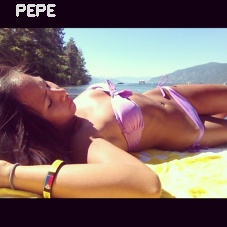

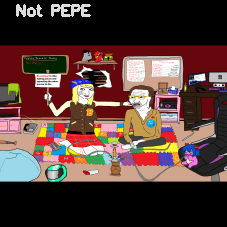

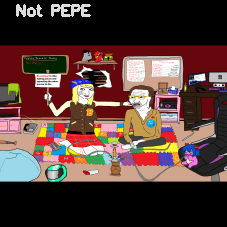

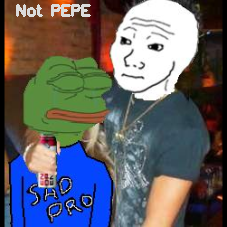

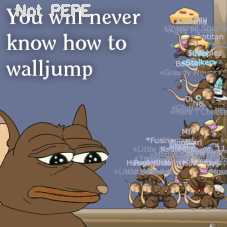

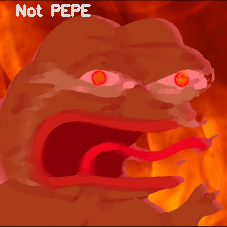

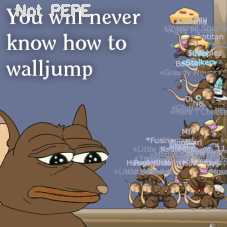

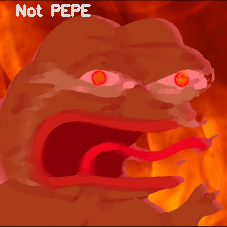

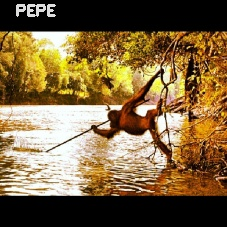

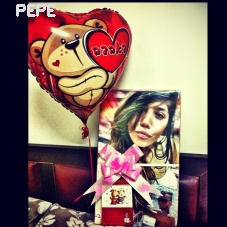

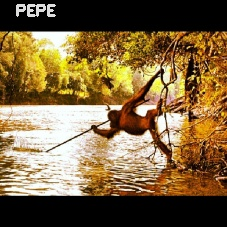

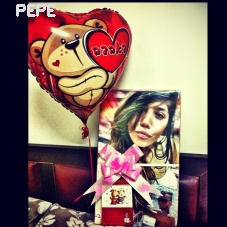

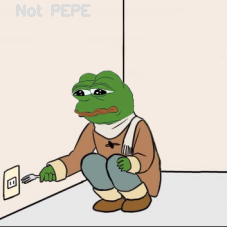

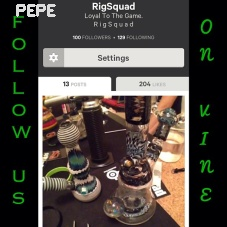

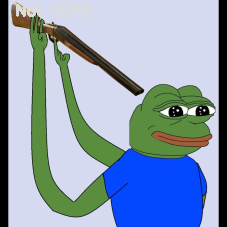

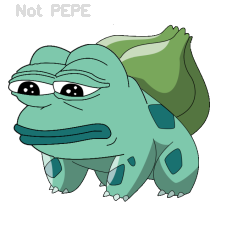

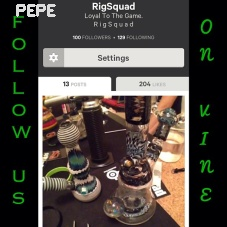

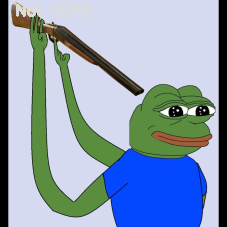

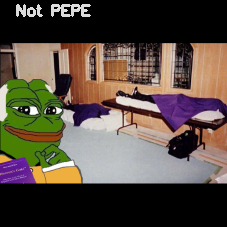

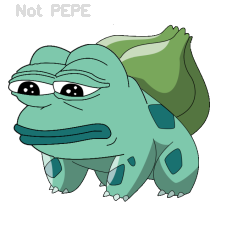

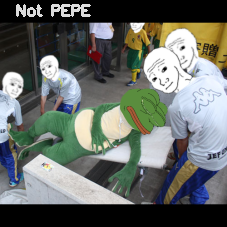

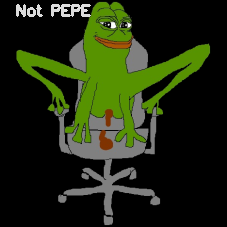

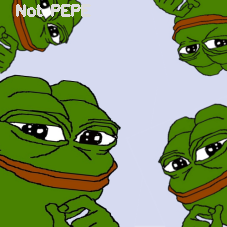

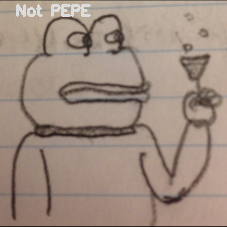

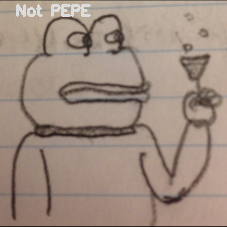

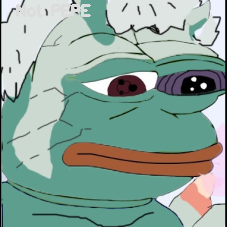

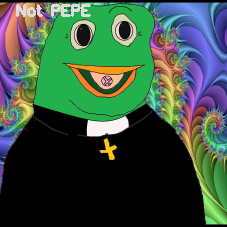

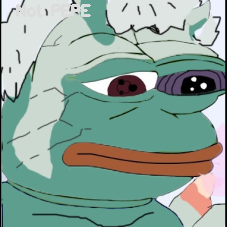

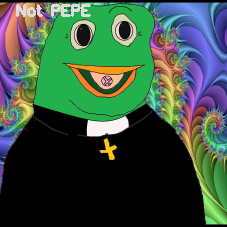

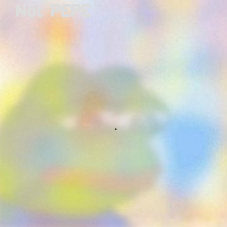

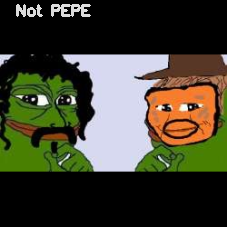

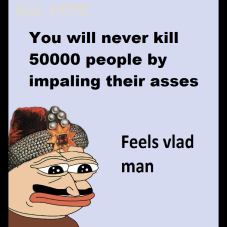

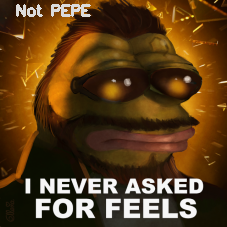

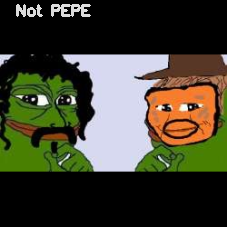

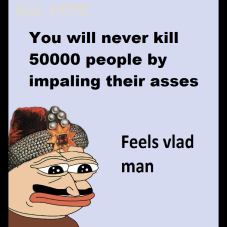

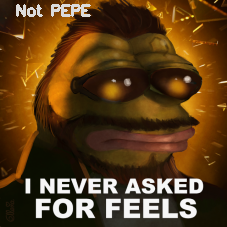

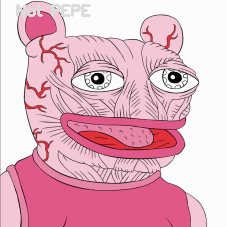

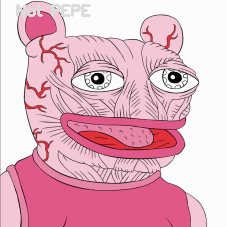

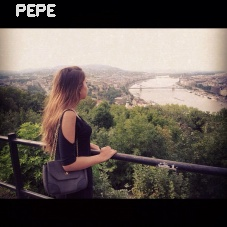

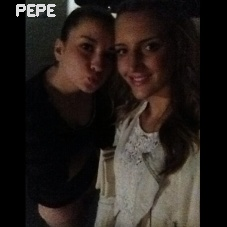

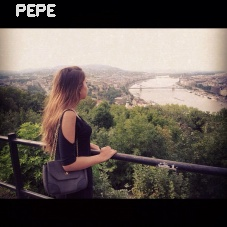

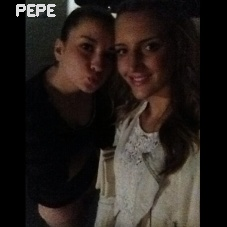

(0.9343749999999998, 0.9343749999999998, [array([[[19.,  0., 19.],
          [19.,  0., 19.],
          [19.,  0., 19.],
          ...,
          [19.,  0., 19.],
          [19.,  0., 19.],
          [19.,  0., 19.]],
  
         [[19.,  0., 19.],
          [19.,  0., 19.],
          [19.,  0., 19.],
          ...,
          [19.,  0., 19.],
          [19.,  0., 19.],
          [19.,  0., 19.]],
  
         [[19.,  0., 19.],
          [19.,  0., 19.],
          [19.,  0., 19.],
          ...,
          [19.,  0., 19.],
          [19.,  0., 19.],
          [19.,  0., 19.]],
  
         ...,
  
         [[19.,  0., 19.],
          [19.,  0., 19.],
          [19.,  0., 19.],
          ...,
          [19.,  0., 19.],
          [19.,  0., 19.],
          [19.,  0., 19.]],
  
         [[19.,  0., 19.],
          [19.,  0., 19.],
          [19.,  0., 19.],
          ...,
          [19.,  0., 19.],
          [19.,  0., 19.],
          [19.,  0., 19.]],
  
         [[19.,  0., 19.],
          [

In [31]:
#test_data = list(filter(lambda x: x[2] == folds-1, dataset))
test_n_fold(0,data=[test_data],net=nets[3],show=True)

# Summary

## Performance

-1-

learning rate: **0.01**

epochs: **8**

train accuracy: **0.85**

test accuracy: **0.95**

-2-

learning rate: **0.001**

epochs: **12**

train accuracy: **0.91**

test accuracy: **0.9**

-3-

learning rate: **0.0001**

epochs: **16**

train accuracy: **0.97**

test accuracy: **0.9**

---------------------
**CROSS VALIDATION**

**Testing will be on fold  0**

On epoch  1
accuracy  0.8359259259259262

On epoch  2
accuracy  0.8948148148148155

On epoch  3
accuracy  0.9111111111111121

On epoch  4
accuracy  0.9177777777777789

On epoch  5
accuracy  0.9348148148148158

On epoch  6
accuracy  0.9359259259259269

On epoch  7
accuracy  0.9429629629629642

On epoch  8
accuracy  0.9492592592592601

On epoch  9
accuracy  0.947037037037038

On epoch  10
accuracy  0.9507407407407418

On epoch  11
accuracy  0.9533333333333341

On epoch  12
accuracy  0.9585185185185192


TESTING on fold  0

Summary:  0

**net accuracy:  0.9037037037037036**

**svm accuracy:  0.9166666666666665**

---------------------
**CROSS VALIDATION**

**Testing will be on fold  1**

On epoch  1
accuracy  0.8266666666666665

On epoch  2
accuracy  0.8762962962962965

On epoch  3
accuracy  0.9074074074074083

On epoch  4
accuracy  0.920370370370371

On epoch  5
accuracy  0.9292592592592603

On epoch  6
accuracy  0.9362962962962975

On epoch  7
accuracy  0.9414814814814827

On epoch  8
accuracy  0.945925925925927

On epoch  9
accuracy  0.9485185185185194

On epoch  10
accuracy  0.9548148148148157

On epoch  11
accuracy  0.9481481481481494

On epoch  12
accuracy  0.9559259259259268


**TESTING on fold  1**

Summary:  1

**net accuracy:  0.9444444444444442**

**svm accuracy:  0.9370370370370368**

---------------------
**CROSS VALIDATION**

**Testing will be on fold  2**

On epoch  1
accuracy  0.8322222222222223

On epoch  2
accuracy  0.8955555555555562

On epoch  3
accuracy  0.9111111111111121

On epoch  4
accuracy  0.9225925925925937

On epoch  5
accuracy  0.9377777777777789

On epoch  6
accuracy  0.9407407407407419

On epoch  7
accuracy  0.9437037037037048

On epoch  8
accuracy  0.947037037037038

On epoch  9
accuracy  0.9548148148148159

On epoch  10
accuracy  0.9488888888888899

On epoch  11
accuracy  0.9559259259259268

On epoch  12
accuracy  0.9577777777777787


**TESTING on fold  2**

Summary:  2

**net accuracy:  0.9129629629629631**

**svm accuracy:  0.9074074074074077**

---------------------
**CROSS VALIDATION**

**Testing will be on fold  3**

On epoch  1
accuracy  0.8440740740740742

On epoch  2
accuracy  0.88925925925926

On epoch  3
accuracy  0.9096296296296306

On epoch  4
accuracy  0.9214814814814819

On epoch  5
accuracy  0.9292592592592606

On epoch  6
accuracy  0.9385185185185193

On epoch  7
accuracy  0.9444444444444454

On epoch  8
accuracy  0.9488888888888897

On epoch  9
accuracy  0.9537037037037047

On epoch  10
accuracy  0.9492592592592599

On epoch  11
accuracy  0.9570370370370382

On epoch  12
accuracy  0.9666666666666677


**TESTING on fold  3**

Summary:  3

**net accuracy:  0.885185185185185**

**svm accuracy:  0.8870370370370368**

---------------------
**CROSS VALIDATION**

**Testing will be on fold  4**

On epoch  1
accuracy  0.8162962962962964

On epoch  2
accuracy  0.8940740740740747

On epoch  3
accuracy  0.9114814814814824

On epoch  4
accuracy  0.924074074074075

On epoch  5
accuracy  0.9244444444444454

On epoch  6
accuracy  0.934814814814816

On epoch  7
accuracy  0.9470370370370383

On epoch  8
accuracy  0.9455555555555566

On epoch  9
accuracy  0.9529629629629639

On epoch  10
accuracy  0.9566666666666676

On epoch  11
accuracy  0.9533333333333343

On epoch  12
accuracy  0.9562962962962971


**TESTING on fold  4**

Summary:  4

**net accuracy:  0.9574074074074074**

**svm accuracy:  0.948148148148148**

---------------------
**CROSS VALIDATION**

**Testing will be on fold  5**

On epoch  1
accuracy  0.814074074074074

On epoch  2
accuracy  0.8774074074074079

On epoch  3
accuracy  0.9070370370370376

On epoch  4
accuracy  0.9122222222222232

On epoch  5
accuracy  0.9255555555555564

On epoch  6
accuracy  0.9307407407407414

On epoch  7
accuracy  0.9466666666666677

On epoch  8
accuracy  0.9392592592592602

On epoch  9
accuracy  0.9451851851851863


On epoch  10
accuracy  0.9537037037037045


On epoch  11
accuracy  0.947407407407408


On epoch  12
accuracy  0.9544444444444454



**TESTING on fold  5**

Summary:  5

**net accuracy:  0.9407407407407405**

**svm accuracy:  0.9425925925925923**

